# AI-Powered URL Phishing Detection System
# Random Forest Classifier for Browser Extension

## Steup and Imports

In [ ]:
!pip install tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 3.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import os
import re
import requests
import tldextract
import joblib
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from urllib.parse import urlparse

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Configuration and Logging

### Set up logging

In [ ]:
log_data = []

def log_event(event_type, message, metadata=None):
    """Log events for research documentation"""
    log_entry = {
        "timestamp": datetime.now().isoformat(),
        "event_type": event_type,
        "message": message,
        "metadata": metadata or {}
    }
    log_data.append(log_entry)
    print(f"[{log_entry['timestamp']}] {event_type}: {message}")

### Define paths

In [ ]:
BASE_PATH = '/content/drive/MyDrive/PUSL3190'
RAW_DATA_PATH = f'{BASE_PATH}/data/raw/phishing_site_urls.csv'
PROCESSED_DATA_PATH = f'{BASE_PATH}/data/processed/browser-extension/browser_extension_features.csv'
MODEL_OUTPUT_PATH = f'{BASE_PATH}/models/random_forest_model/random_forest_model.pkl'
SCALER_OUTPUT_PATH = f'{BASE_PATH}/models/random_forest_model/random_forest_scaler.pkl'
METADATA_OUTPUT_PATH = f'{BASE_PATH}/models/random_forest_model/random_forest_metadata.json'
LOG_OUTPUT_PATH = f'{BASE_PATH}/logs/random_forest_training_log.json'

### Create directories if they don't exist

In [ ]:
os.makedirs(f'{BASE_PATH}/data/processed', exist_ok=True)
os.makedirs(f'{BASE_PATH}/models', exist_ok=True)
os.makedirs(f'{BASE_PATH}/logs', exist_ok=True)

## 1. Data Loading and Exploration

### Load dataset

In [ ]:
log_event("DATA_LOADING", "Loading dataset")
start_time = time.time()

try:
    df = pd.read_csv(RAW_DATA_PATH)
    if 'class' not in df.columns:
        df = df.rename(columns={'label': 'class'})

    if df['class'].dtype == 'object':
        print(f"Converting string labels to numeric. Unique values: {df['class'].unique()}")
        df['class'] = df['class'].map({'good': 0, 'bad': 1, 'legitimate': 0, 'phishing': 1})

    print(f"Class values after conversion: {df['class'].unique()}")
    print(f"Class distribution: {df['class'].value_counts()}")

    # Add HTTPS analysis to understand dataset characteristics
    https_stats = pd.crosstab(df['class'], df['URL'].str.startswith('https'))
    print("\nHTTPS distribution among classes:")
    print(https_stats)
    legitimate_https_pct = https_stats.loc[0, True] / (https_stats.loc[0, True] + https_stats.loc[0, False])
    phishing_https_pct = https_stats.loc[1, True] / (https_stats.loc[1, True] + https_stats.loc[1, False])
    print(f"Legitimate URLs (class 0) using HTTPS: {legitimate_https_pct:.2%}")
    print(f"Phishing URLs (class 1) using HTTPS: {phishing_https_pct:.2%}")

    # Balance dataset only if needed (if classes are imbalanced)
    class_counts = df['class'].value_counts()
    if max(class_counts) / min(class_counts) > 1.1:  # More than 10% difference
        print("\nBalancing dataset...")
        # Downsample the majority class
        majority_class = class_counts.idxmax()
        minority_class = class_counts.idxmin()
        minority_count = class_counts[minority_class]

        df_majority = df[df['class'] == majority_class]
        df_minority = df[df['class'] == minority_class]

        df_majority_downsampled = resample(
            df_majority,
            replace=False,
            n_samples=minority_count,
            random_state=42
        )

        # Combine minority class with downsampled majority class
        df_balanced = pd.concat([df_majority_downsampled, df_minority])
        print(f"Balanced dataset shape: {df_balanced.shape}")

        # Replace original df with balanced df
        df = df_balanced

    log_event("DATA_LOADED", f"Dataset loaded and prepared with shape {df.shape}",
              {"rows": df.shape[0], "columns": df.shape[1]})
except Exception as e:
    log_event("ERROR", f"Failed to load dataset: {str(e)}")
    raise

loading_time = time.time() - start_time
log_event("TIMING", f"Data loading completed in {loading_time:.2f} seconds")

[2025-04-28T12:05:43.868683] DATA_LOADING: Loading dataset
Class values after conversion: [1 0]
Class distribution: class
1    2000
0    2000
Name: count, dtype: int64

HTTPS distribution among classes:
URL    False  True 
class              
0          0   2000
1       1875    125
Legitimate URLs (class 0) using HTTPS: 100.00%
Phishing URLs (class 1) using HTTPS: 6.25%
[2025-04-28T12:05:45.118416] DATA_LOADED: Dataset loaded and prepared with shape (4000, 2)
[2025-04-28T12:05:45.118599] TIMING: Data loading completed in 1.25 seconds


### Display basic information about the dataset

In [ ]:
print("Dataset Information:")
print(f"Total samples: {df.shape[0]}")
print(f"Features: {df.shape[1]}")
print("\nClass Distribution:")
print(df['class'].value_counts())
print("\nFirst 5 rows:")
print(df.head())

Dataset Information:
Total samples: 4000
Features: 2

Class Distribution:
class
1    2000
0    2000
Name: count, dtype: int64

First 5 rows:
                                            URL  class
0  https://start-support-tizer.gitbook.io/en-us      1
1       https://iieudsjwasndjfkdjdd.weebly.com/      1
2           https://0x-turbos.pages.dev/wallets      1
3                   https://shbox.top/yecunoeu/      1
4            https://sparkflrdrops.xyz/clm.html      1


## 2. Feature Extraction for Browser Extension


This section extracts lightweight features suitable for a browser-based phishing detection extension.
We focus on URL characteristics that can be quickly computed in a browser environment.


In [ ]:
log_event("FEATURE_EXTRACTION", "Extracting lightweight features for browser extension")
start_time = time.time()

[2025-04-28T12:06:19.579079] FEATURE_EXTRACTION: Extracting lightweight features for browser extension


Extract lightweight features suitable for browser extension:
  - URL Length
  - Number of dots in domain
  - Number of special characters
  - Presence of IP address
  - Presence of @ symbol
  - Number of subdomains
  - Use of HTTPS
  - Presence of hyphens in domain
  - URL shortener detection
    
These features should be fast to compute in a browser extension


In [ ]:
def extract_lightweight_features(url_df):
    """Extract only critical features suitable for browser extension"""
    features = pd.DataFrame()

    # URL length (critical feature)
    features['url_length'] = url_df['URL'].apply(len)

    # Domain-specific features
    features['num_dots'] = url_df['URL'].apply(lambda x: x.count('.'))

    # Special characters (important signal)
    special_chars = "!@#$%^&*()_+-=[]{}|;:,<>?/\\"
    features['num_special_chars'] = url_df['URL'].apply(lambda x: sum(c in special_chars for c in x))

    # Check if URL uses HTTP
    features['uses_http'] = url_df['URL'].apply(lambda x: 0 if x.startswith('https') else 1)

    # IP address in URL (strong phishing indicator)
    features['has_ip'] = url_df['URL'].apply(
        lambda x: 1 if bool(re.search(r'\d+\.\d+\.\d+\.\d+', x)) else 0)

    # @ symbol in URL (strong phishing indicator)
    features['has_at_symbol'] = url_df['URL'].apply(lambda x: 1 if '@' in x else 0)

    # Domain has hyphen (somewhat indicative)
    features['has_hyphen'] = url_df['URL'].apply(
        lambda x: 1 if '-' in urlparse(x).netloc else 0)

    # URL shortener detection (suspicious)
    url_shorteners = ['bit.ly', 'tinyurl.com', 't.co', 'goo.gl', 'is.gd', 'cli.gs', 'ow.ly']
    features['is_shortened'] = url_df['URL'].apply(
        lambda x: 1 if any(shortener in x for shortener in url_shorteners) else 0)

    # Number of subdomains
    features['num_subdomains'] = url_df['URL'].apply(
        lambda x: len(tldextract.extract(x).subdomain.split('.')) if tldextract.extract(x).subdomain else 0)

    # Target class
    features['is_phishing'] = url_df['class']

    return features

### Extract features

In [ ]:
browser_features = extract_lightweight_features(df)

### Display sample of extracted features

In [ ]:
print("\nExtracted Features (First 5 rows):")
print(browser_features.head())


Extracted Features (First 5 rows):
   url_length  num_dots  num_special_chars  uses_http  has_ip  has_at_symbol  \
0          44         2                  7          0       0              0   
1          39         2                  4          0       0              0   
2          35         2                  5          0       0              0   
3          27         1                  5          0       0              0   
4          34         2                  4          0       0              0   

   has_hyphen  is_shortened  num_subdomains  is_phishing  
0           1             0               1            1  
1           0             0               1            1  
2           1             0               1            1  
3           0             0               0            1  
4           0             0               0            1  


### Save the processed features

In [ ]:
browser_features.to_csv(PROCESSED_DATA_PATH, index=False)

feature_extraction_time = time.time() - start_time
log_event("TIMING", f"Feature extraction completed in {feature_extraction_time:.2f} seconds",
          {"num_features": browser_features.shape[1] - 1})

[2025-04-28T12:06:27.847241] TIMING: Feature extraction completed in 8.27 seconds


## 3. Model Training

This section trains a Random Forest classifier on our extracted features.
Random Forest is chosen for its good performance on classification tasks
and ability to handle non-linear relationships.

In [ ]:
log_event("MODEL_TRAINING", "Starting model training with Random Forest")
start_time = time.time()

[2025-04-28T12:06:29.681631] MODEL_TRAINING: Starting model training with Random Forest


### Prepare features and target

In [ ]:
X = browser_features.drop('is_phishing', axis=1)
y = browser_features['is_phishing']

### Split data (80-20 split)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Log the data split information

In [ ]:
log_event("DATA_SPLIT", "Data split into training and testing sets",
          {"train_samples": X_train.shape[0], "test_samples": X_test.shape[0]})

[2025-04-28T12:06:47.737187] DATA_SPLIT: Data split into training and testing sets


### Feature scaling

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train model

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=20,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

In [ ]:
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=20, n_jobs=-1, random_state=42)

In [ ]:
training_time = time.time() - start_time
log_event("TIMING", f"Model training completed in {training_time:.2f} seconds")

[2025-04-28T12:06:55.915059] TIMING: Model training completed in 26.23 seconds


## 4. Model Evaluation

This section evaluates our trained model using standard classification metrics:
- Accuracy: Overall correctness of predictions
- Precision: Proportion of positive identifications that were actually correct
- Recall: Proportion of actual positives that were identified correctly
- F1 Score: Harmonic mean of precision and recall
- AUC: Area under the ROC curve

In [ ]:
log_event("MODEL_EVALUATION", "Evaluating Random Forest model")
start_time = time.time()

[2025-04-28T12:06:58.007659] MODEL_EVALUATION: Evaluating Random Forest model


### Make predictions

In [ ]:
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

### Calculate metrics

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

### ROC curve and AUC

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

### Log the evaluation metrics

In [ ]:
log_event("EVALUATION_METRICS", "Model performance metrics", {
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "auc": float(roc_auc)
})

[2025-04-28T12:07:03.399908] EVALUATION_METRICS: Model performance metrics


### Print model performance

In [ ]:
print("\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")


Model Performance:
Accuracy: 0.9825
Precision: 0.9949
Recall: 0.9700
F1 Score: 0.9823
AUC: 0.9968


## 5. Visualization of Results

This section visualizes key aspects of our model performance:
- Confusion Matrix: Shows the true positive, false positive, true negative, and false negative counts
- ROC Curve: Shows the trade-off between sensitivity and specificity
- Feature Importance: Shows which features are most influential in the model's predictions

### Plot confusion matrix

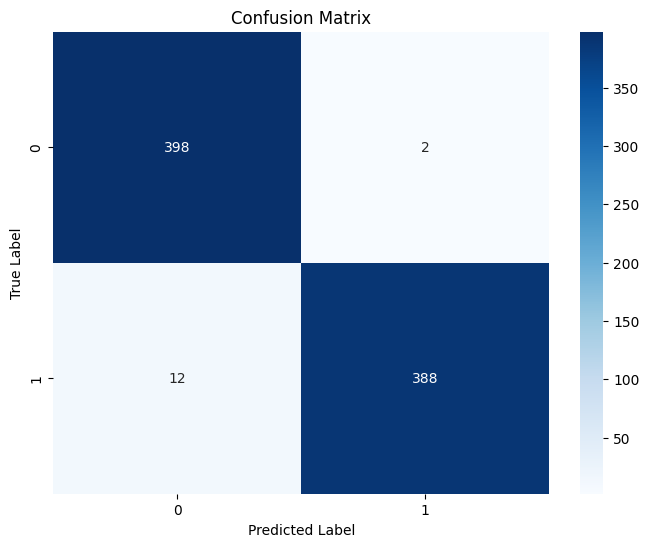

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Plot ROC curve

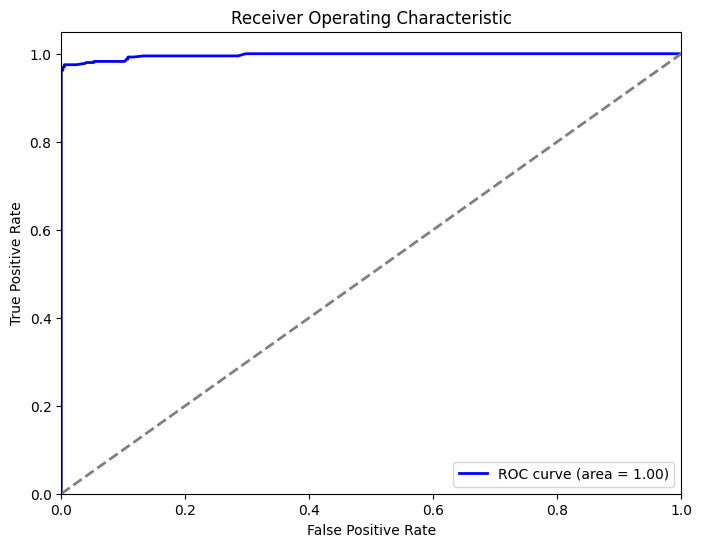

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Feature importance

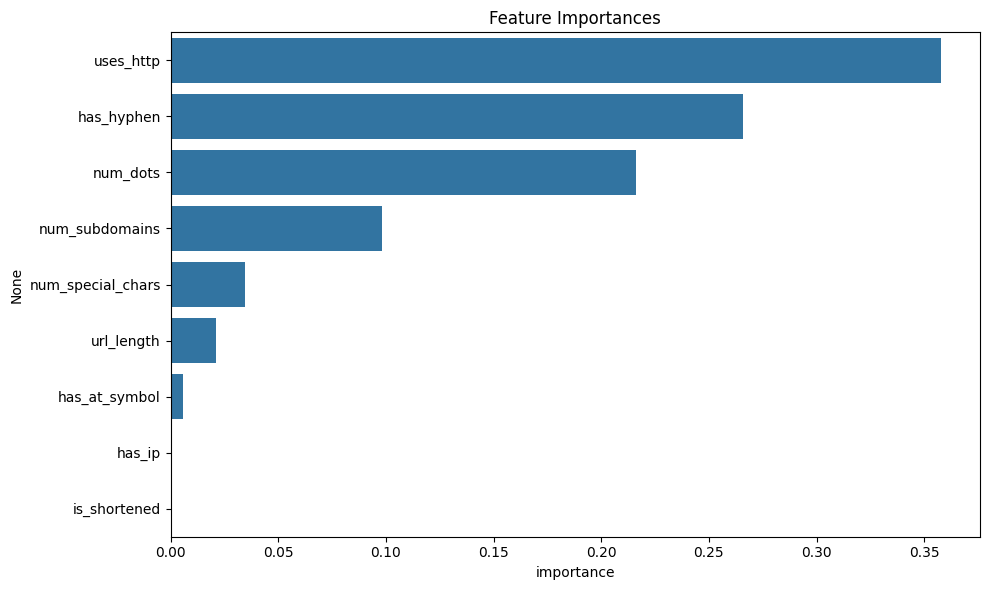

[2025-04-28T12:07:17.610092] TIMING: Model evaluation completed in 19.60 seconds


In [ ]:
feature_importances = pd.DataFrame(
    rf_model.feature_importances_,
    index=X.columns,
    columns=['importance']
).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

evaluation_time = time.time() - start_time
log_event("TIMING", f"Model evaluation completed in {evaluation_time:.2f} seconds")

## 6. Testing

In [ ]:
log_event("MODEL_TESTING", "Testing model with well-known domains")
start_time = time.time()

[2025-04-28T12:07:23.198675] MODEL_TESTING: Testing model with well-known domains


### Testing with Real-World Examples

In [ ]:
# Test URLs from test data
print("\nTesting model with known URLs from test data:")

# Define test URLs - sample from test data
good_mask = (y_test == 0)
bad_mask = (y_test == 1)

# Get a few examples of each class
good_urls = X_test[good_mask].iloc[:3]
bad_urls = X_test[bad_mask].iloc[:3]

# Function to test prediction
def test_prediction(features, label, expected_class):
    features_scaled = scaler.transform(features)
    pred_class = rf_model.predict(features_scaled)
    pred_proba = rf_model.predict_proba(features_scaled)

    for i in range(len(features)):
        print(f"{label} URL #{i+1}:")
        print(f"  Predicted class: {pred_class[i]} ({'Phishing' if pred_class[i] == 1 else 'Legitimate'})")
        print(f"  Probability of phishing: {pred_proba[i][1]:.4f}")
        print(f"  Probability of legitimate: {pred_proba[i][0]:.4f}")
        print(f"  Correct prediction: {pred_class[i] == expected_class}")
        print()

print("Testing legitimate URLs from dataset:")
test_prediction(good_urls, "Legitimate", 0)

print("Testing phishing URLs from dataset:")
test_prediction(bad_urls, "Phishing", 1)


Testing model with known URLs from test data:
Testing legitimate URLs from dataset:
Legitimate URL #1:
  Predicted class: 0 (Legitimate)
  Probability of phishing: 0.0075
  Probability of legitimate: 0.9925
  Correct prediction: True

Legitimate URL #2:
  Predicted class: 0 (Legitimate)
  Probability of phishing: 0.0427
  Probability of legitimate: 0.9573
  Correct prediction: True

Legitimate URL #3:
  Predicted class: 0 (Legitimate)
  Probability of phishing: 0.0012
  Probability of legitimate: 0.9988
  Correct prediction: True

Testing phishing URLs from dataset:
Phishing URL #1:
  Predicted class: 1 (Phishing)
  Probability of phishing: 0.9975
  Probability of legitimate: 0.0025
  Correct prediction: True

Phishing URL #2:
  Predicted class: 1 (Phishing)
  Probability of phishing: 0.9975
  Probability of legitimate: 0.0025
  Correct prediction: True

Phishing URL #3:
  Predicted class: 1 (Phishing)
  Probability of phishing: 0.9975
  Probability of legitimate: 0.0025
  Correct pre

In [ ]:
print("\nTesting model on well-known legitimate sites (CRUCIAL TEST):")

# Create test samples with known good domains
test_domains = [
    "https://www.youtube.com/watch?v=abcdefgh",
    "https://github.com/username/repository",
    "https://www.google.com/search?q=test",
    "https://www.amazon.com/product",
    "http://example.com"  # Intentionally using HTTP
]

for domain in test_domains:
    # We need to create a DataFrame with the URL first to run it through our feature extraction
    features = extract_lightweight_features(pd.DataFrame({'URL': [domain], 'class': [0]})).drop('is_phishing', axis=1)
    features_scaled = scaler.transform(features)
    pred_class = rf_model.predict(features_scaled)[0]
    pred_proba = rf_model.predict_proba(features_scaled)[0]

    print(f"Domain: {domain}")
    print(f"  Predicted class: {pred_class} ({'Phishing' if pred_class == 1 else 'Legitimate'})")
    print(f"  Probability of phishing: {pred_proba[1]:.4f}")
    print(f"  Probability of legitimate: {pred_proba[0]:.4f}")
    print(f"  Expected prediction: Legitimate")
    print(f"  ✓ CORRECT" if pred_class == 0 else f"  ✗ INCORRECT - This would require whitelist")
    print()


Testing model on well-known legitimate sites (CRUCIAL TEST):
Domain: https://www.youtube.com/watch?v=abcdefgh
  Predicted class: 0 (Legitimate)
  Probability of phishing: 0.0308
  Probability of legitimate: 0.9692
  Expected prediction: Legitimate
  ✓ CORRECT

Domain: https://github.com/username/repository
  Predicted class: 0 (Legitimate)
  Probability of phishing: 0.1840
  Probability of legitimate: 0.8160
  Expected prediction: Legitimate
  ✓ CORRECT

Domain: https://www.google.com/search?q=test
  Predicted class: 0 (Legitimate)
  Probability of phishing: 0.0361
  Probability of legitimate: 0.9639
  Expected prediction: Legitimate
  ✓ CORRECT

Domain: https://www.amazon.com/product
  Predicted class: 0 (Legitimate)
  Probability of phishing: 0.0615
  Probability of legitimate: 0.9385
  Expected prediction: Legitimate
  ✓ CORRECT

Domain: http://example.com
  Predicted class: 1 (Phishing)
  Probability of phishing: 0.8474
  Probability of legitimate: 0.1526
  Expected prediction: Le

## 6. Model Saving

This section saves the trained model and other artifacts:
- Full model for server-side use
- Model metadata for tracking
- Preprocessing scaler for future use

In [ ]:
log_event("MODEL_SAVING", "Saving model and artifacts")
start_time = time.time()

[2025-04-28T12:07:44.701762] MODEL_SAVING: Saving model and artifacts


### Save the model

In [ ]:
joblib.dump(rf_model, MODEL_OUTPUT_PATH)

['/content/drive/MyDrive/PUSL3190/models/random_forest_model/random_forest_model.pkl']

### Save the scaler for future preprocessing

In [ ]:
joblib.dump(scaler, SCALER_OUTPUT_PATH)

['/content/drive/MyDrive/PUSL3190/models/random_forest_model/random_forest_scaler.pkl']

### Save model parameters and metadata

In [ ]:
model_info = {
    "name": "random_forest_model_lite",
    "type": "random_forest",
    "version": "1.0",
    "trained_at": datetime.now().isoformat(),
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "auc": float(roc_auc),
    "parameters": {
        "n_estimators": rf_model.n_estimators,
        "max_depth": rf_model.max_depth,
        "min_samples_split": rf_model.min_samples_split,
        "min_samples_leaf": rf_model.min_samples_leaf
    },
    "feature_list": list(X.columns),
    "model_size_bytes": os.path.getsize(MODEL_OUTPUT_PATH),
    "label_encoding": {
        "0": "legitimate",
        "1": "phishing"
    },
    "feature_importances": {
        "importance": {name: float(importance) for name, importance in zip(X.columns, rf_model.feature_importances_)}
    },
    "dataset_info": {
        "total_samples": df.shape[0],
        "legitimate_samples": int(np.sum(df['class'] == 0)),
        "phishing_samples": int(np.sum(df['class'] == 1)),
    }
}

with open(METADATA_OUTPUT_PATH, 'w') as f:
    json.dump(model_info, f, indent=2)

## 7. Summary

### Save all logs to file

In [ ]:
saving_time = time.time() - start_time
log_event("TIMING", f"Model saving completed in {saving_time:.2f} seconds")

[2025-04-28T12:07:55.156586] TIMING: Model saving completed in 10.45 seconds


In [ ]:
def save_logs_with_append(log_data, log_file_path):
    try:
        with open(log_file_path, 'r') as f:
            try:
                existing_logs = json.load(f)
                if not isinstance(existing_logs, list):
                    existing_logs = []
            except json.JSONDecodeError:
                existing_logs = []
    except FileNotFoundError:
        existing_logs = []

    combined_logs = existing_logs + log_data

    with open(log_file_path, 'w') as f:
        json.dump(combined_logs, f, indent=2)

    print(f"Appended {len(log_data)} new log entries to {log_file_path}")
    return combined_logs

log_data = save_logs_with_append(log_data, LOG_OUTPUT_PATH)

saving_time = time.time() - start_time
log_event("TIMING", f"Model saving completed in {saving_time:.2f} seconds")

Appended 14 new log entries to /content/drive/MyDrive/PUSL3190/logs/random_forest_training_log.json
[2025-04-28T12:07:56.919910] TIMING: Model saving completed in 12.22 seconds


In [ ]:
log_data = save_logs_with_append(log_data, LOG_OUTPUT_PATH)

Appended 288 new log entries to /content/drive/MyDrive/PUSL3190/logs/random_forest_training_log.json


### Training details

In [ ]:
print("\n===== TRAINING COMPLETE =====")
print(f"Lightweight model accuracy: {accuracy:.4f}")
print(f"Model saved to {MODEL_OUTPUT_PATH}")
print(f"Metadata saved to {METADATA_OUTPUT_PATH}")
print(f"Logs saved to {LOG_OUTPUT_PATH}")


===== TRAINING COMPLETE =====
Lightweight model accuracy: 0.9825
Model saved to /content/drive/MyDrive/PUSL3190/models/random_forest_model/random_forest_model.pkl
Metadata saved to /content/drive/MyDrive/PUSL3190/models/random_forest_model/random_forest_metadata.json
Logs saved to /content/drive/MyDrive/PUSL3190/logs/random_forest_training_log.json
